In [281]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report


Import data

In [237]:
df = pd.read_csv("/Users/jane/Documents/课件/capstone/default.csv",header=1) 
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [238]:
df = df.iloc[:,1:]
df.columns = [x.lower() for x in df.columns]
df.rename(columns={'pay_0':'pay_1'}, inplace=True)
df=df.drop_duplicates(keep = 'first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29965 entries, 0 to 29999
Data columns (total 24 columns):
limit_bal                     29965 non-null int64
sex                           29965 non-null int64
education                     29965 non-null int64
marriage                      29965 non-null int64
age                           29965 non-null int64
pay_1                         29965 non-null int64
pay_2                         29965 non-null int64
pay_3                         29965 non-null int64
pay_4                         29965 non-null int64
pay_5                         29965 non-null int64
pay_6                         29965 non-null int64
bill_amt1                     29965 non-null int64
bill_amt2                     29965 non-null int64
bill_amt3                     29965 non-null int64
bill_amt4                     29965 non-null int64
bill_amt5                     29965 non-null int64
bill_amt6                     29965 non-null int64
pay_amt1                

Data Cleaning

Here I deleted first row and coloum, and lowercased the name of coloum for convience.It seems there is no missing value but I still need to further check the data.

In [239]:
df.head()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [240]:
df[df.columns[1:11]].describe()

,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
count,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000
mean,1.603738,1.853629,1.551877,35.487969,-0.016753,-0.131854,-0.164392,-0.218922,-0.264509,-0.289438
std,0.489128,0.790411,0.521997,9.219459,1.123492,1.196322,1.195878,1.168175,1.132220,1.149090
min,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


According to the observation, the geneder colunm looks good, but education has values equal to 0,5 and 6, and marriage has values equal to 0, which are not listed in the data description.In order know more about the characters of these outliers, I calculated each label's default rate.

In [241]:
#df['education'] = df['education'].replace('0','4')
#df['marriage'] = df['marriage'].replace('0','3')
#df[['marriage']].describe()
#df.loc[df.marriage ==0, 'marriage'] = 3
#df.loc[(df['education'] ==0) | (df['education']==5)|(df['education']==6)]=4
#df.describe()

In [242]:
marriage=df[['marriage','default payment next month']]
ma_default=marriage.groupby(['marriage','default payment next month']).size().unstack()
ma_default['default_percentage']=ma_default[1]/np.sum(ma_default, axis=1)
#ma_default.columns=['non-default','default','default_percentage']
#ma_default.index=['married','single','other']
ma_default

default payment next month,0,1,default_percentage
marriage,,,
0,49,5,0.092593
1,10442,3201,0.234626
2,12605,3340,0.209470
3,239,84,0.260062


In [243]:
edu=df[['education','default payment next month']]
edu_default=edu.groupby(['education','default payment next month']).size().unstack()
edu_default.fillna(0,inplace=True)
edu_default['default_percentage']=edu_default[1]/np.sum(edu_default, axis=1)
edu_default

default payment next month,0,1,default_percentage
education,,,
0,14.0,0.0,0.000000
1,8531.0,2032.0,0.192370
2,10691.0,3328.0,0.237392
3,3678.0,1237.0,0.251679
4,116.0,7.0,0.056911
5,262.0,18.0,0.064286
6,43.0,8.0,0.156863


The default rate in the column 'marriage=0' is 0.35.I was thinking to classify them into the 'other' label in 'marriage',but the default rate in 'other' label is 0.017, which may violate the final outcome if I do so. I found a revelent data:'Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.'. Still, there is no further explainsion about data values which are no specified in the data description. Since there are 29964 data in the database,and the outliers are not that many, I decided to drop these unspecified data.

In [244]:
pay_columns=df.columns[5:11]
print(df[pay_columns].describe())


              pay_1         pay_2         pay_3         pay_4         pay_5  \
count  29965.000000  29965.000000  29965.000000  29965.000000  29965.000000   
mean      -0.016753     -0.131854     -0.164392     -0.218922     -0.264509   
std        1.123492      1.196322      1.195878      1.168175      1.132220   
min       -2.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000      8.000000      8.000000      8.000000      8.000000   

              pay_6  
count  29965.000000  
mean      -0.289438  
std        1.149090  
min       -2.000000  
25%       -1.000000  
50%        0.000000  
75%        0.000000  
max        8.000000  


In [245]:
df.loc[~df['marriage'].isin([0])&~df['education'].isin([0,5,6])&~df['pay_1'].isin([-2])&~df['pay_2'].isin([-2])
       &~df['pay_3'].isin([-2])&~df['pay_4'].isin([-2])&~df['pay_5'].isin([-2])&~df['pay_6'].isin([-2])]

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default payment next month
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
10,200000,2,3,2,34,0,0,2,0,0,...,2513,1828,3731,2306,12,50,300,3738,66,0
11,260000,2,1,2,51,-1,-1,-1,-1,-1,...,8517,22287,13668,21818,9966,8583,22301,0,3640,0


If I drop rows when the values of label pay_1~6 equal to -2, I will loss over 20% of data. Now I'm trying to classify them.

In [246]:
shiwo=df.marriage==0
shiwo.sum()

54

In [247]:
pay1=df[['pay_1','default payment next month']]
pay_default1=pay1.groupby(['pay_1','default payment next month']).size().unstack()
pay_default1.fillna(0,inplace=True)
pay_default1['default_percentage']=pay_default1[1]/np.sum(pay_default1, axis=1)
pay_default1

default payment next month,0,1,default_percentage
pay_1,,,
-2,2386,364,0.132364
-1,4728,954,0.167899
0,12849,1888,0.128113
1,2419,1248,0.340333
2,823,1843,0.691298
3,78,244,0.757764
4,24,52,0.684211
5,13,13,0.500000
6,5,6,0.545455


In [248]:
pay2=df[['pay_2','default payment next month']]
pay_default2=pay2.groupby(['pay_2','default payment next month']).size().unstack()
pay_default2.fillna(0,inplace=True)
pay_default2['default_percentage']=pay_default2[1]/np.sum(pay_default2, axis=1)
pay_default2

default payment next month,0,1,default_percentage
pay_2,,,
-2,3066.0,686.0,0.182836
-1,5080.0,966.0,0.159775
0,13227.0,2503.0,0.159123
1,23.0,5.0,0.178571
2,1743.0,2183.0,0.556037
3,125.0,201.0,0.616564
4,49.0,50.0,0.505051
5,10.0,15.0,0.600000
6,3.0,9.0,0.750000


In [249]:
pay3=df[['pay_3','default payment next month']]
pay_default3=pay3.groupby(['pay_3','default payment next month']).size().unstack()
pay_default3.fillna(0,inplace=True)
pay_default3['default_percentage']=pay_default3[1]/np.sum(pay_default3, axis=1)
pay_default3

default payment next month,0,1,default_percentage
pay_3,,,
-2,3303,752,0.185450
-1,5008,926,0.156050
0,13013,2751,0.174512
1,3,1,0.250000
2,1850,1969,0.515580
3,102,138,0.575000
4,32,43,0.573333
5,9,12,0.571429
6,9,14,0.608696


In [250]:
pay4=df[['pay_4','default payment next month']]
pay_default4=pay4.groupby(['pay_4','default payment next month']).size().unstack()
pay_default4.fillna(0,inplace=True)
pay_default4['default_percentage']=pay_default4[1]/np.sum(pay_default4, axis=1)
pay_default4

default payment next month,0,1,default_percentage
pay_4,,,
-2,3486,832,0.192682
-1,4779,904,0.159071
0,13439,3016,0.183288
1,1,1,0.500000
2,1506,1653,0.523267
3,70,110,0.611111
4,23,45,0.661765
5,17,18,0.514286
6,3,2,0.400000


In [251]:
pay5=df[['pay_5','default payment next month']]
pay_default5=pay5.groupby(['pay_5','default payment next month']).size().unstack()
pay_default5.fillna(0,inplace=True)
pay_default5['default_percentage']=pay_default5[1]/np.sum(pay_default5, axis=1)
pay_default5

default payment next month,0,1,default_percentage
pay_5,,,
-2,3626.0,890.0,0.197077
-1,4638.0,897.0,0.162060
0,13752.0,3195.0,0.188529
2,1203.0,1423.0,0.541889
3,65.0,113.0,0.634831
4,33.0,50.0,0.602410
5,7.0,10.0,0.588235
6,1.0,3.0,0.750000
7,10.0,48.0,0.827586


In [252]:
pay6=df[['pay_6','default payment next month']]
pay_default6=pay6.groupby(['pay_6','default payment next month']).size().unstack()
pay_default6.fillna(0,inplace=True)
pay_default6['default_percentage']=pay_default6[1]/np.sum(pay_default, axis=1)
pay_default6

default payment next month,0,1,default_percentage
pay_6,,,
-2,3889.0,976.0,0.354892
-1,4761.0,975.0,0.171589
0,13217.0,3069.0,0.208250
2,1365.0,1401.0,0.525567
3,66.0,118.0,0.365599
4,18.0,30.0,0.391215
5,6.0,7.0,0.264151
6,5.0,14.0,1.212598
7,8.0,38.0,3.886364


I found that the default rate is similar between value -2 and 0. This method is loose, but I don't want to loss too much data so this is best way I can find.

In [253]:
shiwo=df.marriage==0
shiwo.sum()

54

df.loc[(df['pay_1'] ==-2) | (df['pay_2']==-2)|(df['pay_3']==-2)|(df['pay_4']==-2)|(df['pay_5']==-2)|(df['pay_6']==-2)]=0


In [254]:
shiwo=df.sex==0
shiwo.sum()

0

In [255]:
df.head(11)

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,20000,1,3,2,35,-2,-2,-2,-2,-1,...,0,13007,13912,0,0,0,13007,1122,0,0


#replace = df.pay_1|df.pay_2|df.pay_3|df.pay_4|df.pay_5|df.pay_6==-2
replaces=df.iloc[:,5:11]
column_names=["pay_1","pay_2","pay_3","pay_4","pay_5","pay_6"]
for i in replaces:
    for j in column_names:
        if df.loc[j, i] == -2:
            df.loc[j, i] = 0
#replace = df.pay_1==-2
#column_name = 'pay_1'
#df.loc[replace, column_name] = 0
df.head(10)


In [256]:
replace = df.pay_1==-2
column_name = 'pay_1'
df.loc[replace, column_name] = 0
replace = df.pay_2==-2
column_name = 'pay_2'
df.loc[replace, column_name] = 0
replace = df.pay_3==-2
column_name = 'pay_3'
df.loc[replace, column_name] = 0
replace = df.pay_4==-2
column_name = 'pay_4'
df.loc[replace, column_name] = 0
replace = df.pay_5==-2
column_name = 'pay_5'
df.loc[replace, column_name] = 0
replace = df.pay_6==-2
column_name = 'pay_6'
df.loc[replace, column_name] = 0
df.head(10)

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,0,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,20000,1,3,2,35,0,0,0,0,-1,...,0,13007,13912,0,0,0,13007,1122,0,0


In [257]:
#df[(df['marriage']==0)|(df['education']==0)]
#df.loc[~df['marriage'].isin([0])&~df['education'].isin([0,5,6])&~df['pay_1'].isin([-2])&~df['pay_2'].isin([-2])&~df['pay_3'].isin([-2])&~df['pay_4'].isin([-2])&~df['pay_5'].isin([-2])&~df['pay_6'].isin([-2])]
#df.loc[~df['marriage'].isin([0])&~df['education'].isin([0,5,6])]

In [258]:
df=df.loc[~df['marriage'].isin([0])&~df['education'].isin([0,5,6])]
df.describe()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default payment next month
count,29566.000000,29566.000000,29566.000000,29566.000000,29566.000000,29566.000000,29566.000000,29566.000000,29566.000000,29566.000000,...,29566.000000,29566.000000,29566.000000,29566.000000,2.956600e+04,29566.000000,29566.000000,29566.000000,29566.000000,29566.000000
mean,167507.734560,1.603193,1.815937,1.555469,35.466549,0.167591,0.120375,0.108774,0.071433,0.038693,...,43173.448826,40283.022188,38904.296625,5656.150511,5.901669e+03,5204.472029,4834.277684,4800.611344,5187.362274,0.223196
std,129956.897864,0.489244,0.710396,0.518115,9.214821,0.933155,0.969422,0.954259,0.915232,0.868404,...,64217.315034,60719.565223,59540.184856,16576.958525,2.310199e+04,17590.433956,15719.502905,15252.372084,17666.834745,0.416395
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2360.000000,1803.500000,1299.000000,1000.000000,8.360000e+02,390.000000,300.000000,264.250000,150.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19037.000000,18121.000000,17153.500000,2100.000000,2.009000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54339.000000,50138.250000,49205.750000,5006.000000,5.000000e+03,4500.000000,4019.000000,4057.750000,4000.000000,0.000000
max,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

X2: Gender (1 = male; 2 = female). 

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 

X4: Marital status (1 = married; 2 = single; 3 = others). 

X5: Age (year). 
_____________________________________________________________________________________________
X6 - X11: 
History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows:
X6 = the repayment status in September, 2005; 
X7 = the repayment status in August, 2005;
. . .;
X11 = the repayment status in April, 2005. 
The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
______________________________________________________________________________________________
X12-X17:
Amount of bill statement (NT dollar).
X12 = amount of bill statement in September, 2005; 
X13 = amount of bill statement in August, 2005;
. . .; 
X17 = amount of bill statement in April, 2005. 
______________________________________________________________________________________________
X18-X23: 
Amount of previous payment (NT dollar).
X18 = amount paid in September, 2005; 
X19 = amount paid in August, 2005; 
. . .;
X23 = amount paid in April, 2005. 

In [354]:
default_rate=np.sum(df['default payment next month'])/29566
default_rate

0.2231955624704052

In [259]:
marriage=df[['marriage','default payment next month']]
ma_default=marriage.groupby(['marriage','default payment next month']).size().unstack()
ma_default['default_percentage']=ma_default[1]/np.sum(ma_default, axis=1)
ma_default.columns=['non-default','default','default_percentage']
ma_default.index=['married','single','other']
print(ma_default)

         non-default  default  default_percentage
married        10274     3187            0.236758
single         12459     3328            0.210806
other            234       84            0.264151


In [260]:
edu=df[['education','default payment next month']]
edu_default=edu.groupby(['education','default payment next month']).size().unstack()
edu_default.fillna(0,inplace=True)
edu_default['default_percentage']=edu_default[1]/np.sum(edu_default, axis=1)
edu_default.columns=['non-default','default','default_percentage']
edu_default.index=['graduate ','graduate ','high school','others']
print(edu_default)

             non-default  default  default_percentage
graduate            8527     2032            0.192442
graduate           10686     3327            0.237422
high school         3638     1233            0.253131
others               116        7            0.056911


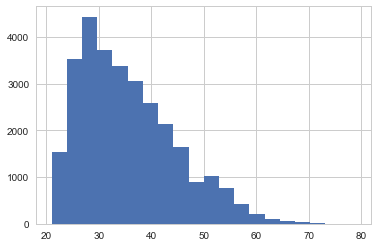

In [261]:
plt.hist('age', data=df,bins=20)
plt.show()

In [262]:
age_default=df[['age','default payment next month']]
age_default=age_default.groupby(['age','default payment next month']).size().unstack()
#age_default=age_default['default_percentage']=age_default[1]/np.sum(age_default, axis=1)
#sns.regplot(x='age',y='default_percentage',data=age)
#plt.scatter(x='age',y='default_percentage')
#plt.show()
#np.sum(age_default,axis=1)

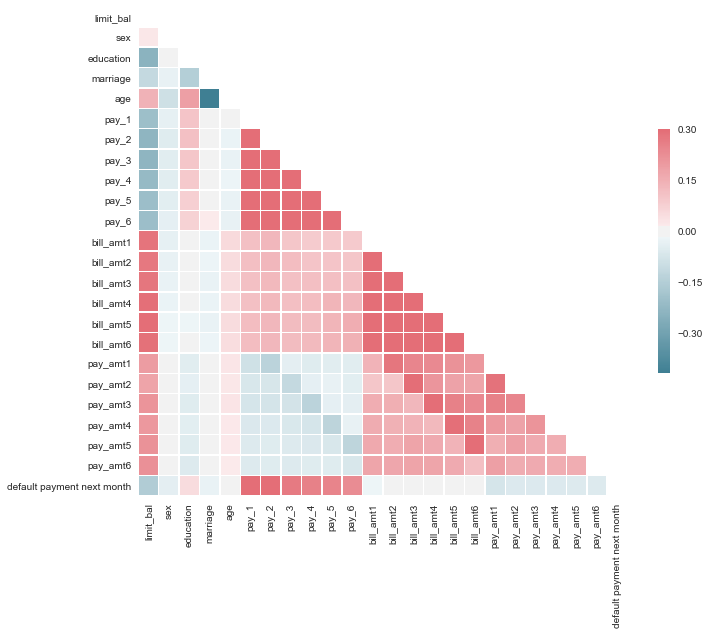

In [263]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

The correlation method here is questionable 

Now, I'm trying to visualize the data, and finding corr.

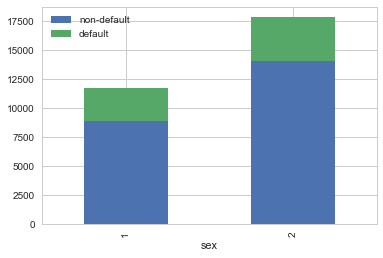

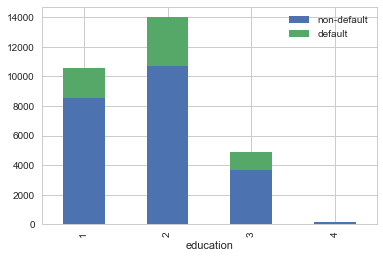

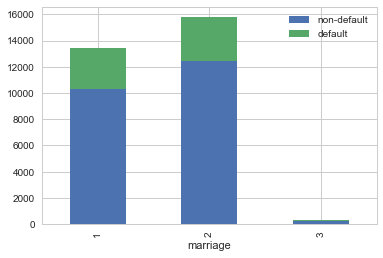

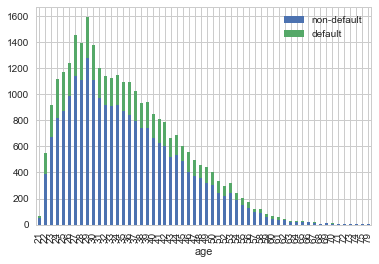

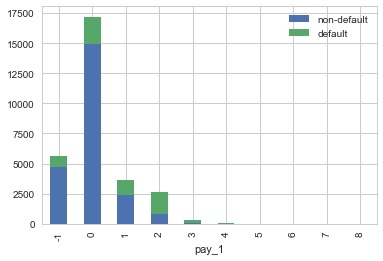

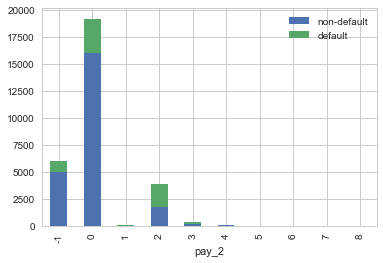

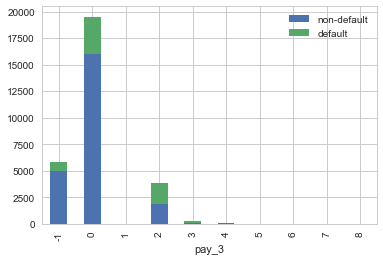

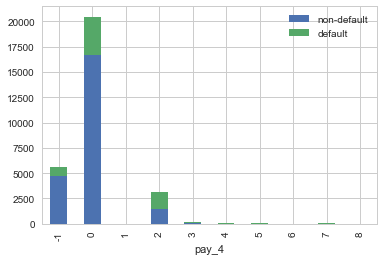

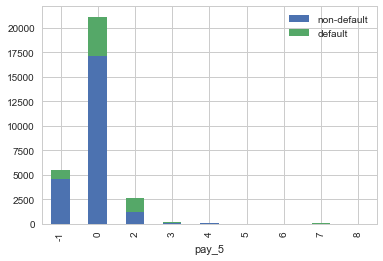

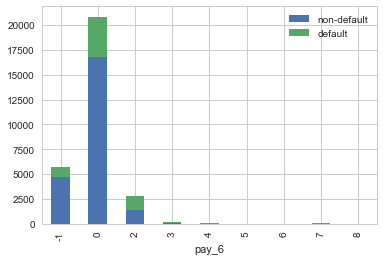

In [264]:
a=df.columns
a=a.drop(a[11:])
a=a.drop(a[0])
b=[x for x in a]
# print(b)
# x=df.groupby([b[3],'default payment next month']).size().unstack()
for i in range(len(b)):
    _ = df.groupby([b[i],'default payment next month']).size().unstack()
    _.plot(kind='bar', stacked=True)
    plt.legend(['non-default','default'])
    plt.show()

In [265]:
#_=df.groupby(['sex','default payment next month']).size().unstack()
#_=df.groupby(['education','default payment next month']).size().unstack()
#_=df.groupby(['marriage','default payment next month']).size().unstack()
#_.plot(kind='bar', stacked=True)
#plt.show()

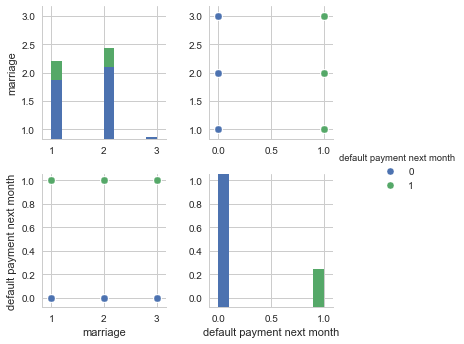

In [266]:
sns.pairplot(df[['marriage','default payment next month']],hue= 'default payment next month')
plt.show()

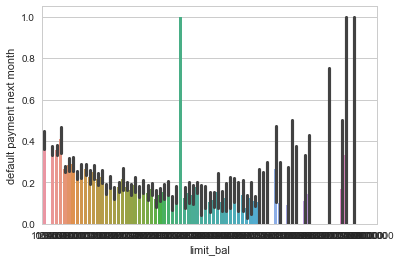

In [267]:
sns.set(style="whitegrid")
ax = sns.barplot(x="limit_bal", y="default payment next month", data=df)
plt.show()

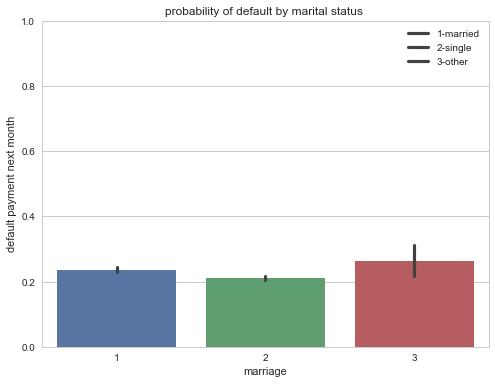

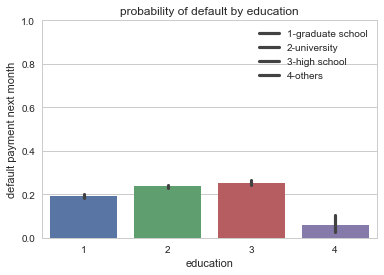

In [268]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x="marriage", y="default payment next month", data=df)
plt.ylim((0, 1))
plt.title('probability of default by marital status ')
plt.legend(labels=['1-married', '2-single','3-other'],  loc='best')
plt.show()

ax = sns.barplot(x="education", y="default payment next month", data=df)

plt.title('probability of default by education')
plt.legend(labels=["1-graduate school","2-university", "3-high school","4-others"],  loc='best')
plt.ylim((0, 1))
plt.show()

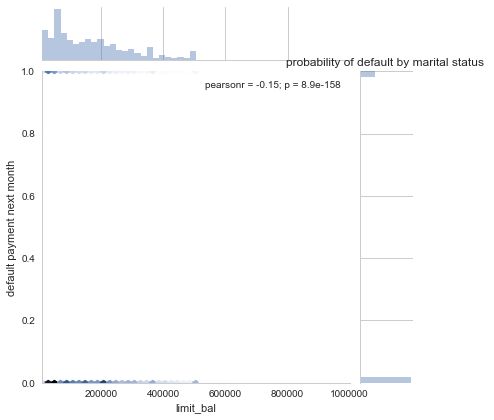

In [269]:
sns.set(style="whitegrid")
ax = sns.jointplot(x="limit_bal", y='default payment next month', data=df,kind='hex')
plt.title('probability of default by marital status ')
plt.show()

In [270]:
age_default=pd.crosstab(df['age'],df['default payment next month'])
age_default['default percentage']=age_default[1]/(age_default[0]+age_default[1])
print(age_default)

default payment next month     0    1  default percentage
age                                                      
21                            50   14            0.218750
22                           386  167            0.301989
23                           670  246            0.268559
24                           817  299            0.267921
25                           874  301            0.256170
26                           989  252            0.203062
27                          1141  312            0.214728
28                          1109  285            0.204448
29                          1277  313            0.196855
30                          1107  274            0.198407
31                           973  228            0.189842
32                           918  224            0.196147
33                           913  214            0.189885
34                           915  231            0.201571
35                           872  226            0.205829
36            

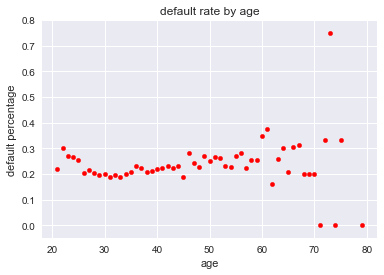

In [335]:
plt.figure(figsize=(12,12))
age_default.reset_index().plot(kind='scatter', x='age', y='default percentage',color="red")
plt.title('default rate by age')
plt.show()

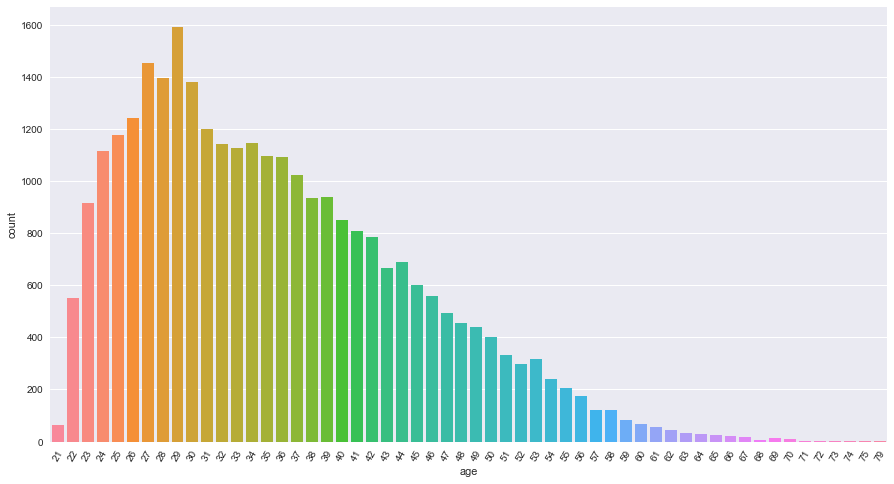

In [332]:
sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(15, 8))
#sns.set(style="whitegrid")
sns.countplot(x="age", data=df,saturation=8)
plt.xticks(rotation=60)
plt.show()

In [304]:
#sns.barplot(x="sex", y="survived", hue="class", data=titanic)

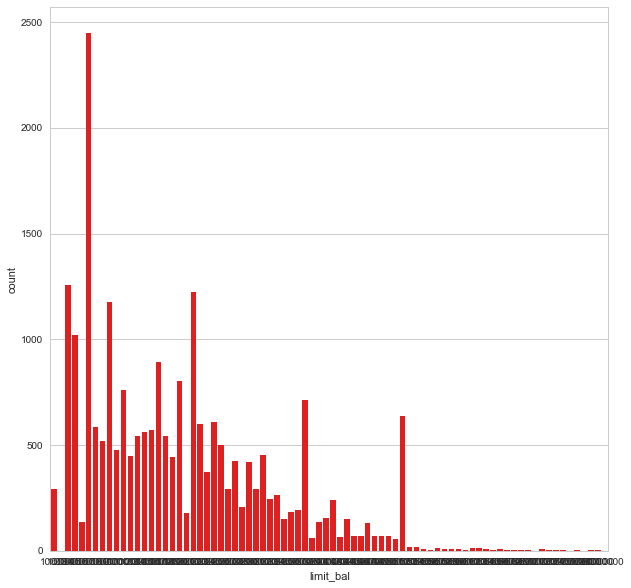

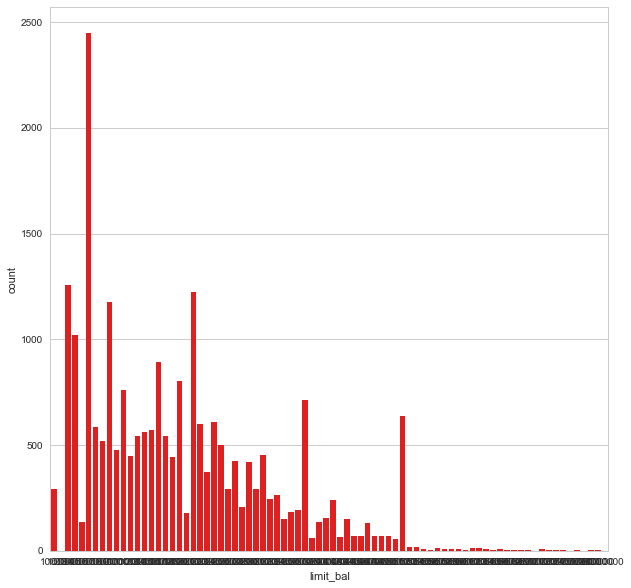

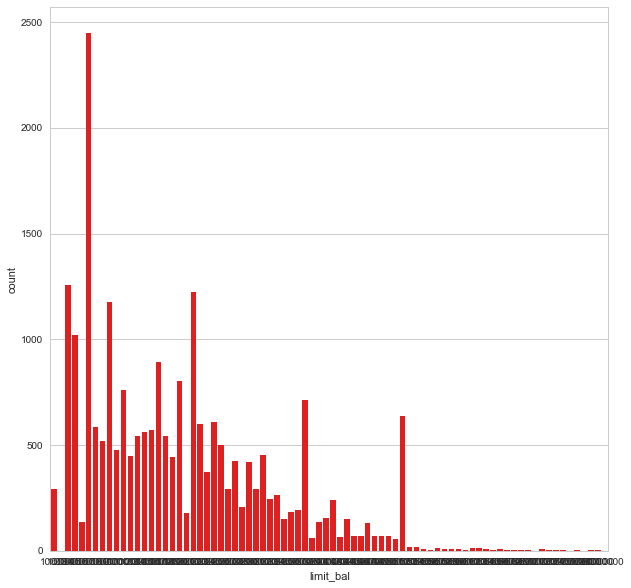

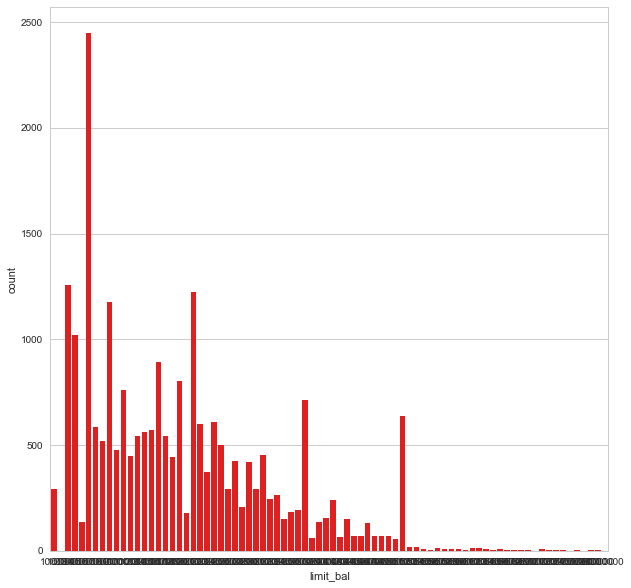

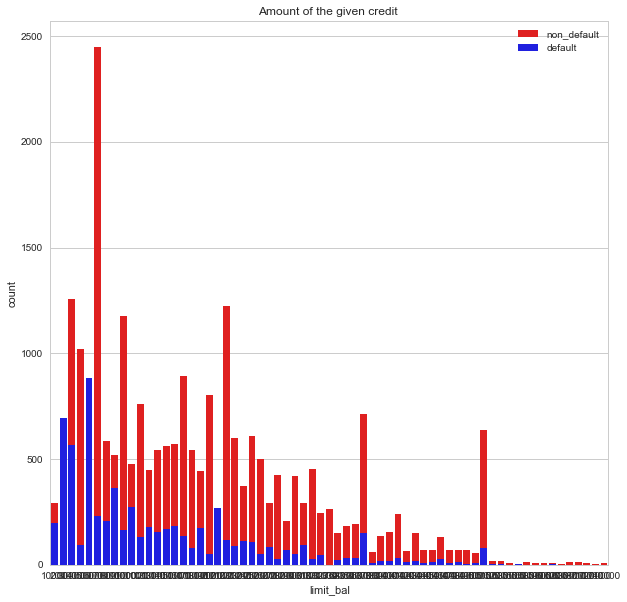

In [348]:
sns.set(style="whitegrid")
amount=df[['limit_bal','default payment next month']]
nondefault=amount.loc[amount['default payment next month'].isin([0])]
default=amount.loc[amount['default payment next month'].isin([1])]
plt.figure(figsize=(10, 10))
pic_node=sns.countplot(nondefault['limit_bal'],color='red')
pic_de=sns.countplot(default['limit_bal'],color='blue')
plt.title('Amount of the given credit ')
plt.legend(labels=['non_default', 'default'],  loc='best')
plt.show()
#amount.fillna(0,inplace=True)
#amount=amount.loc[~df['default payment next month'].isin([0])]
#pay=df[['pay_5','default payment next month']]
#amount_default=amount.groupby(['limit_bal','default payment next month']).size().unstack()
#pay_default.fillna(0,inplace=True)
#amount_default['default_percentage']=amount_default[amount_default['limit_bal']<100000&amount_default[1]]/np.sum(pay_default, axis=1)


In [274]:
bill_statement=df.iloc[:,11:17]
pay_statement=df.iloc[:,17:23]
bill_statement.columns=[1,2,3,4,5,6]
pay_statement.columns=[1,2,3,4,5,6]
diff=bill_statement.subtract(pay_statement,fill_value=0)
limit_bal=df['limit_bal']

ratio=diff.div(limit_bal,axis=0)
ratio.head()

,1,2,3,4,5,6
0,0.195650,0.120650,0.034450,0.000000,0.000000,0.000000
1,0.022350,0.006042,0.014017,0.018933,0.028792,0.010508
2,0.308011,0.139189,0.139544,0.148122,0.154978,0.117211
3,0.899800,0.924280,0.961820,0.544280,0.557800,0.570940
4,0.132340,-0.620220,0.516700,0.238800,0.369140,0.369040


In [275]:
diff.head()

,1,2,3,4,5,6
0,3913,2413,689,0,0,0
1,2682,725,1682,2272,3455,1261
2,27721,12527,12559,13331,13948,10549
3,44990,46214,48091,27214,27890,28547
4,6617,-31011,25835,11940,18457,18452


In [276]:
limit_bal.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: limit_bal, dtype: int64

In [279]:
#df1.div(df2.iloc[0], axis='columns')

KNN

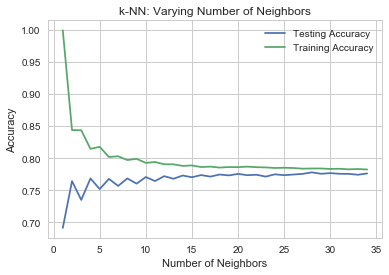

In [284]:
from sklearn.preprocessing import StandardScaler

y = df['default payment next month'].values
X = df.drop('default payment next month', axis=1).values
#X = scale(X)


neighbors = np.arange(1, 35)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()



In [283]:
# Import scale
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Scale the features: X_scaled
X_scaled = scale(X)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=18))]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Fit the pipeline to the training set: knn_scaled
knn_scaled = pipeline.fit(X_train,y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
#knn_unscaled = KNeighborsClassifier().fit(X_train, y_train)

# Compute and print metrics
#print('Accuracy with Scaling: {}'.format(knn_scaled.score(X_test,y_test)))
#print('Accuracy without Scaling: {}'.format(knn_unscaled.score(X_test,y_test)))


# Predict the labels of the test data: y_pred
y_pred = knn_scaled.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[[4348  243]
 [ 931  392]]
             precision    recall  f1-score   support

          0       0.82      0.95      0.88      4591
          1       0.62      0.30      0.40      1323

avg / total       0.78      0.80      0.77      5914



/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


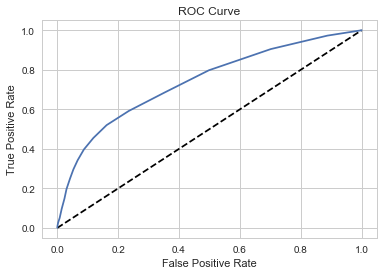

In [285]:
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = knn_scaled.predict_proba(X_test)[:,1]


# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [286]:
# Import necessary modules
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(knn_scaled,X,y,cv=5,scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))


/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data w

AUC scores computed using 5-fold cross-validation: [ 0.71887986  0.72996044  0.75527953  0.76251229  0.75428789]


logistic

In [287]:
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space,'penalty': ['l1', 'l2']}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameters: {'C': 0.43939705607607948, 'penalty': 'l1'}
Best score is 0.8114049922207942


In [288]:


# Create the classifier: logreg
logreg = LogisticRegression(C=3.7275937203149381,penalty='l2')

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('log', LogisticRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Fit the pipeline to the training set: knn_scaled
log_scaled = pipeline.fit(X_train,y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
log_unscaled = LogisticRegression().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(log_scaled.score(X_test,y_test)))
print('Accuracy without Scaling: {}'.format(log_unscaled.score(X_test,y_test)))


/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Accuracy with Scaling: 0.8047007101792357
Accuracy without Scaling: 0.7761244504565438


In [289]:
# Predict the labels of the test data: y_pred
y_pred = log_scaled.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[4408  183]
 [ 972  351]]
             precision    recall  f1-score   support

          0       0.82      0.96      0.88      4591
          1       0.66      0.27      0.38      1323

avg / total       0.78      0.80      0.77      5914



/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


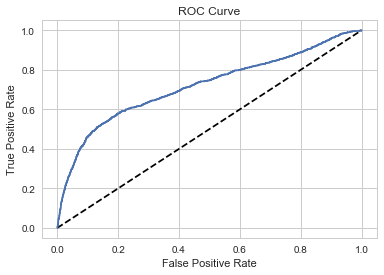

In [290]:
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = log_scaled.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [291]:
# Import necessary modules
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(log_scaled,X,y,cv=5,scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data w

AUC scores computed using 5-fold cross-validation: [ 0.69841575  0.71045773  0.74042078  0.75336274  0.74854762]


Random Forest

In [292]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
RF = RandomForestClassifier(random_state = 16)
RF.fit(X_train, y_train)
print("accuracy score: {}".format(accuracy_score(RF.predict(X_test), y_test)))

accuracy score: 0.8031788975312817


In [293]:
# Create the hyperparameter grid
n_estimators = np.arange(5,20)
max_depth=np.arange(5,30)
param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}

# Instantiate the logistic regression classifier: logreg
random = RandomForestClassifier()

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
random_cv = GridSearchCV(random,param_grid,cv=5)

# Fit it to the training data
random_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned RandomForest Parameter: {}".format(random_cv.best_params_))
print("Tuned RandomForest Accuracy: {}".format(random_cv.best_score_))





Tuned RandomForest Parameter: {'max_depth': 8, 'n_estimators': 18}
Tuned RandomForest Accuracy: 0.8216923163650713


In [359]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])

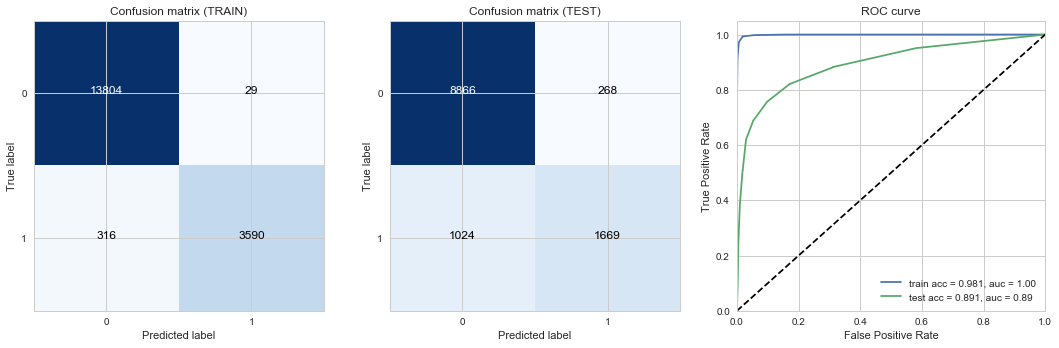

In [295]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score

threshold = 0.5
y_train_pred = RF.predict_proba(X_train)[:,1]
y_test_pred = RF.predict_proba(X_test)[:,1]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

In [296]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create the classifier: logreg
DA = LinearDiscriminantAnalysis()

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('da',LinearDiscriminantAnalysis())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Fit the pipeline to the training set: knn_scaled
da_scaled = pipeline.fit(X_train,y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
da_unscaled = LinearDiscriminantAnalysis().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(da_scaled.score(X_test,y_test)))
print('Accuracy without Scaling: {}'.format(da_unscaled.score(X_test,y_test)))

/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Accuracy with Scaling: 0.8052079810618871
Accuracy without Scaling: 0.8052079810618871


In [355]:
# Predict the labels of the test data: y_pred
y_pred = da_scaled.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4383  208]
 [ 944  379]]
             precision    recall  f1-score   support

          0       0.82      0.95      0.88      4591
          1       0.65      0.29      0.40      1323

avg / total       0.78      0.81      0.77      5914



/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


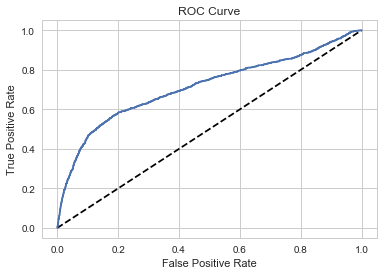

In [356]:
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = da_scaled.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [357]:
# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(da_scaled,X,y,cv=5,scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data w

AUC scores computed using 5-fold cross-validation: [ 0.6942763   0.70580838  0.73834071  0.74844469  0.74566077]


/Users/jane/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


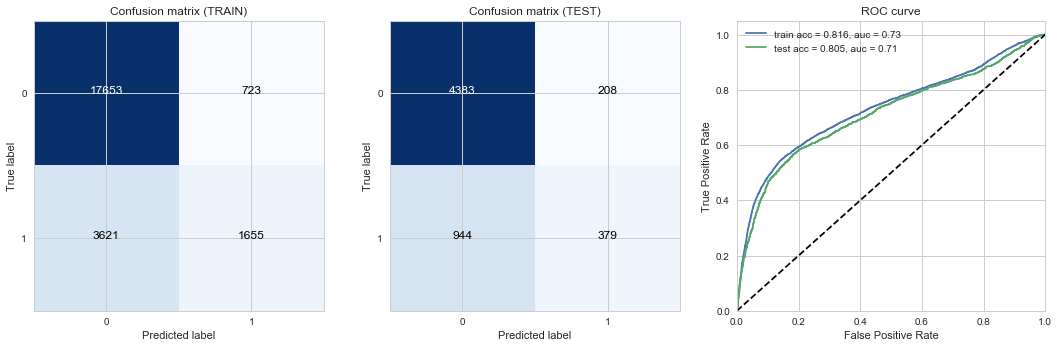

In [361]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score

threshold = 0.5
y_train_pred = da_scaled.predict_proba(X_train)[:,1]
y_test_pred = da_scaled.predict_proba(X_test)[:,1]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()